In [2]:
#!python -m spacy download fr_core_news_md
#nlp = spacy.load('fr_core_news_md')

In [3]:
#pip install scikit-optimize

# Import packages

In [5]:
# Import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import to load arff file from url
from scipy.io import arff
import urllib.request
import io 

# Sklearn import
from sklearn.model_selection import train_test_split # Splitting the data set
from sklearn.preprocessing import MinMaxScaler, StandardScaler # Normalization and standard scaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # Label and 1-hot encoding
from sklearn.linear_model import LogisticRegression # Logistic regression model
from sklearn.linear_model import LogisticRegressionCV # Logistic regression with cross-validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score  # Accuracy
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score  # Precision, recall, and f1 score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import RFE
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mariana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import os
os.system('pip install spacy')
#os.system('python -m spacy download fr_core_news_sm')


0

In [7]:
import spacy
import string
nlp = spacy.load('fr_core_news_sm')

# Introduction


### Exploring the base rate

In [10]:
# Training data
training = pd.read_csv('https://github.com/cvermno/ML-Project/raw/main/Datasets/training_data.csv')
# Test data
test = pd.read_csv('https://github.com/cvermno/ML-Project/raw/main/Datasets/unlabelled_test_data.csv')

In [11]:
training_difficulty = training['difficulty'].value_counts()
training_difficulty_100 = training['difficulty'].value_counts(normalize=True)*100
print(training_difficulty)
print(training_difficulty_100)

difficulty
A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: count, dtype: int64
difficulty
A1    16.9375
C2    16.8125
C1    16.6250
B1    16.5625
A2    16.5625
B2    16.5000
Name: proportion, dtype: float64


In [12]:
labels = training['difficulty'].unique().tolist()
labels

['C1', 'A1', 'B1', 'A2', 'B2', 'C2']

# Extracting Features
## What defines a sentence complexity? 
The length of the sentence, The richness of the vocabulary, The grammar or the syntax?
Before diving into machine learning models we will translate sentences into metrics and numbers.
We selected the following features to explore:
1. Word count: total tokens considered as words in the sentence.
2. Average word length
3. Sentence_length: total number oh characters
4. Rare words count
5. Number of syllables
6. Vocabulary richness
7. POS Tags Distribution: Proportion of different parts of speech (nouns, verbs, adjectives, etc.).
8. Number of clauses
9. Punctuation count
10. Named entities: words that are names of persons, organizations, locations, dates etc.
11. Conjugations
12. Word similarity: mean, median and variance of the pairwise cosine similarity between the word vectors 

In [14]:
import pandas as pd
import spacy
import numpy as np
from collections import Counter

# Load SpaCy model with word vectors
nlp = spacy.load('fr_core_news_md')

# Function to count syllables
def count_syllables(word):
    # Simple heuristic for French syllable counting
    vowels = 'aeiouyâêîôûàèùéëïüÿœæ'
    count = 0
    previous_char_was_vowel = False
    for char in word.lower():
        if char in vowels:
            if not previous_char_was_vowel:
                count += 1
                previous_char_was_vowel = True
        else:
            previous_char_was_vowel = False
    return count

# List of all possible POS tags
all_pos_tags = [
    'ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ',
    'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'SPACE'
]

# Function to extract features from a sentence
def extract_features(sentence, rare_word_threshold=-7):
    doc = nlp(sentence)
    
    features = {}
    features['word_count'] = len(doc)
    features['average_word_length'] = sum(len(token) for token in doc) / len(doc)
    features['sentence_length'] = len(sentence)
    features['rare_words_count'] = sum(1 for token in doc if token.is_alpha and token.prob < rare_word_threshold)
    features['num_syllables'] = sum(count_syllables(token.text) for token in doc)
    features['vocabulary_richness'] = len(set(token.text for token in doc)) / len(doc)
    
    # Initialize POS tag counts to zero
    for pos in all_pos_tags:
        features[f'pos_count_{pos}'] = 0

    # Update POS tag counts with actual values
    pos_counts = Counter([token.pos_ for token in doc])
    for pos, count in pos_counts.items():
        features[f'pos_count_{pos}'] = count
    
    features['num_clauses'] = len(list(doc.sents))
    features['punctuation_count'] = sum(1 for token in doc if token.is_punct)
    features['named_entities'] = len(doc.ents)
    features['conjugations'] = sum(1 for token in doc if token.pos_ == 'VERB')
    
    # Word similarity features
    word_vectors = np.array([token.vector for token in doc if token.has_vector and not token.is_stop and not token.is_punct])
    if len(word_vectors) < 2:
        features['mean_similarity'] = 0
        features['median_similarity'] = 0
        features['variance_similarity'] = 0
    else:
        #Cosine similarity = dot product of vectors divided by their magnitudes
        similarities = [np.dot(word_vectors[i], word_vectors[j]) / (np.linalg.norm(word_vectors[i]) * np.linalg.norm(word_vectors[j]))
                        for i in range(len(word_vectors)) for j in range(i + 1, len(word_vectors))]
        features['mean_similarity'] = np.mean(similarities)
        features['median_similarity'] = np.median(similarities)
        features['variance_similarity'] = np.var(similarities)
    
    return features


In [15]:
# Extract and append features to the DataFrame
features_list = []
for sentence in training['sentence']:
    features = extract_features(sentence)
    features_list.append(features)

features_df = pd.DataFrame(features_list)
training = pd.concat([training, features_df], axis=1)

training

,id,sentence,difficulty,word_count,average_word_length,sentence_length,rare_words_count,num_syllables,vocabulary_richness,pos_count_ADJ,...,pos_count_VERB,pos_count_X,pos_count_SPACE,num_clauses,punctuation_count,named_entities,conjugations,mean_similarity,median_similarity,variance_similarity
0,0,Les coûts kilométriques réels peuvent diverger...,C1,45,4.844444,255,37,73,0.711111,3,...,4,0,0,1,5,0,4,0.334505,0.336255,0.023137
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,16,3.187500,62,12,16,1.000000,1,...,1,0,0,1,2,0,1,0.335962,0.241904,0.052694
2,2,Le test de niveau en français est sur le site ...,A1,15,3.600000,66,13,20,0.933333,1,...,1,0,0,1,1,1,1,0.183211,0.171467,0.028210
3,3,Est-ce que ton mari est aussi de Boston?,A1,10,3.300000,40,8,12,1.000000,0,...,0,0,0,1,1,1,0,0.032159,0.037518,0.006980
4,4,"Dans les écoles de commerce, dans les couloirs...",B1,42,4.190476,209,31,58,0.738095,2,...,4,0,0,1,5,0,4,0.166466,0.169475,0.026392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,4795,"C'est pourquoi, il décida de remplacer les hab...",B2,30,4.666667,165,26,50,0.966667,3,...,5,0,0,1,3,0,5,0.164488,0.136956,0.031709
4796,4796,Il avait une de ces pâleurs splendides qui don...,C1,22,4.454545,118,21,36,0.954545,2,...,2,0,0,1,1,1,2,0.173281,0.093819,0.032889
4797,4797,"Et le premier samedi de chaque mois, venez ren...",A2,15,4.466667,80,13,22,0.933333,1,...,2,0,0,1,2,0,2,0.137010,0.102325,0.013758
4798,4798,Les coûts liés à la journalisation n'étant pas...,C2,37,5.270270,226,32,71,0.864865,5,...,1,0,0,1,2,0,1,0.346568,0.349739,0.022780


In [16]:
training.to_csv('training_features.csv')

In [17]:
# Finding a useful threshold for rare_words_count. We will consider a word rare if it has a 0.1% frequency 
max_words = training['word_count'].max()
mean_words = training['word_count'].mean()
total_words = training['word_count'].sum()
lowest_probability_log = np.log(103/total_words)
print(max_words)
print (mean_words)
print(total_words)
print(lowest_probability_log)

304
21.525
103320
-6.9108572589801405


# Logistic Regression, KNN, Decision tree and Random forest

## 01 Extracted features

As a first attempt we will train and test a Logistic Regression, KNN, Decision tree and Random forest model with all the features extracted on the previous section and compare their confusion matrices and metrics (precission, recall, f1 score and accuracy).

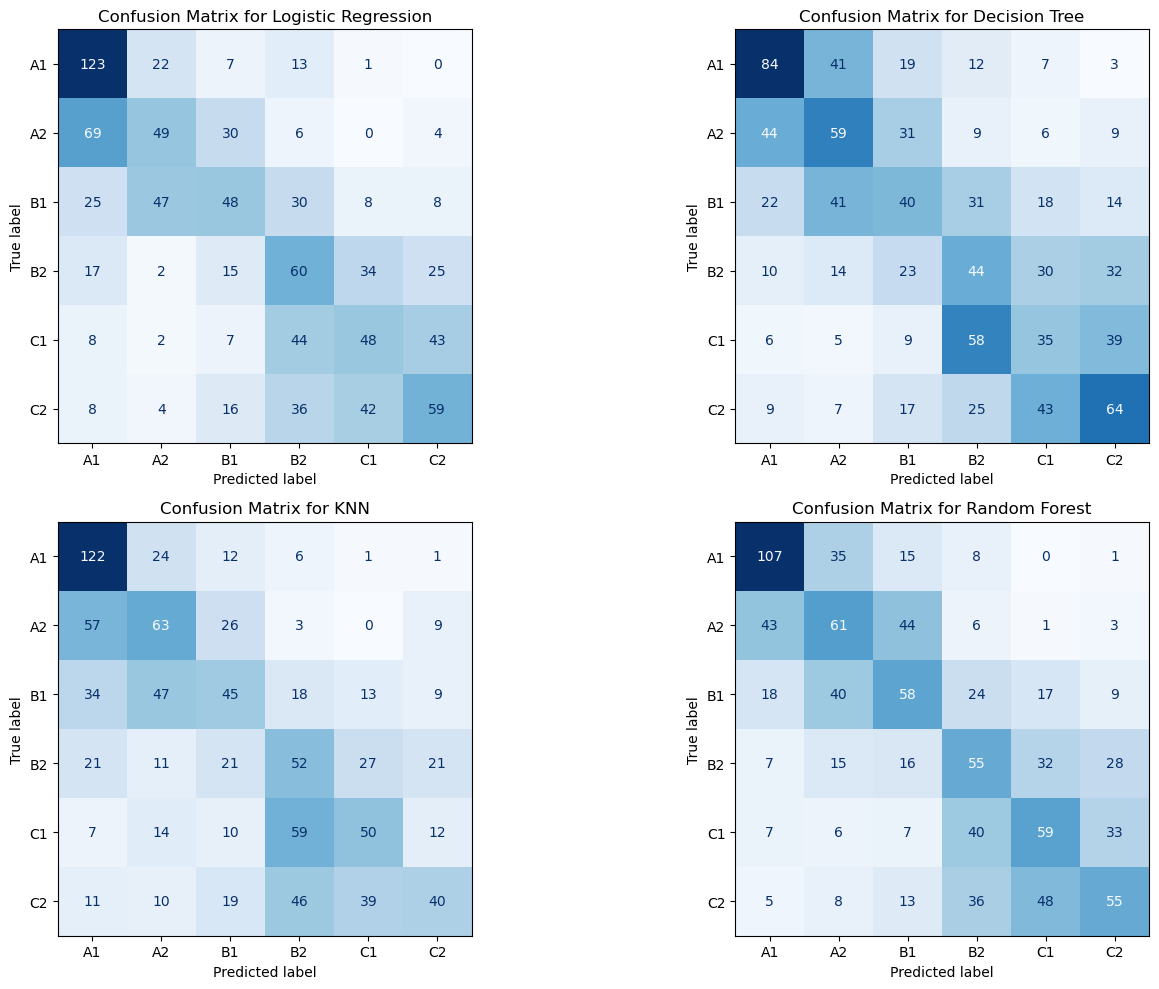

,Logistic Regression,KNN,Decision Tree,Random Forest
Precision,0.396,0.383,0.336,0.408
Recall,0.401,0.386,0.338,0.410
F1-score,0.391,0.374,0.336,0.408
Accuracy,0.403,0.388,0.340,0.411


In [21]:
# Split the data into features (X) and labels (y)
X = training.drop(columns=['id', 'sentence', 'difficulty'])
#X = training(columns=['word_count', 'rare_words_count'])
y = training['difficulty']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier()
}
#---------------------------------------------------------------------------------------------------
# Train the models
y_preds = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_preds[name] = model.predict(X_test_scaled)

# Initialize a DataFrame to hold the evaluation metrics
metrics_df = pd.DataFrame(index=['Precision', 'Recall', 'F1-score', 'Accuracy'],
                          columns=['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest'])

# Evaluate the models and populate the DataFrame
for name, y_pred in y_preds.items():
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    metrics_df.loc['Precision', name] = np.mean([report[label]['precision'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['Recall', name] = np.mean([report[label]['recall'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['F1-score', name] = np.mean([report[label]['f1-score'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['Accuracy', name] = accuracy_score(y_test, y_pred)

# Plot confusion matrices using ConfusionMatrixDisplay
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for ax, (name, y_pred) in zip(axes, y_preds.items()):
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', colorbar=False)
    disp.ax_.set_title(f'Confusion Matrix for {name}')

plt.tight_layout()
plt.show()
metrics_df_ef = metrics_df.map(lambda x: f"{x:.3f}")
metrics_df_ef

Random Forest seems to be so far the best method to classify sentences based on difficulty. We will now reflect on what the strengths and weaknesses of model are to explain these results and define next steps.

**Logistic Regression** is a linear model used for binary and multiclass classification by estimating class belonging probabilities with a logistic (sigmoid) function that is applied to the weighted sum of the input features. It is simple, interpretable, and works well with sparse data like TF-IDF features but as it is a linear model, it might struggle with complex, non-linear relationships in the data for example contextual information.
Also the boundaries between A1-A2, B1-B2, and C1-C2 seem to be difficult to find as we can see from the confusion matrix highliting the limitation of a Logistic Regression linear boundary.

**Decision Tree** splits the data into subsets based on feature values in a way that nodes represents features, branches decision rules, and leaves a class labels.
- The tree is built by choosing the feature that best separates the data according to a criterion like Gini impurity or information gain.

**Suitability for Text**:
- **Advantages**: Decision Trees can capture non-linear relationships and are easy to interpret.
- **Disadvantages**: They can easily overfit, especially with high-dimensional data like TF-IDF vectors.

**Example**:
- For a sentence classification task, a Decision Tree might split the data first on the presence of a specific word or word frequency, then further split on other words or features until it reaches a decision.

### Random Forest

**How it works**:
- Random Forest is an ensemble of Decision Trees. Each tree is trained on a random subset of the data and features, and their predictions are combined (usually by voting) to make the final prediction.
- This reduces overfitting and improves generalization.

**Suitability for Text**:
- **Advantages**: Random Forests handle non-linear relationships well, are less prone to overfitting than individual Decision Trees, and can manage high-dimensional data.
- **Disadvantages**: They are more complex and harder to interpret than single Decision Trees.

**Example**:
- For text classification, Random Forests would build multiple Decision Trees, each potentially focusing on different word combinations or frequencies. The ensemble would combine these to provide a robust classification.

### K-Nearest Neighbors (KNN)

**How it works**:
- KNN is a non-parametric, instance-based learning algorithm. It classifies a data point based on the majority class of its `k` nearest neighbors in the feature space.
- Distance metrics like Euclidean or cosine similarity are used to find the nearest neighbors.

**Suitability for Text**:
- **Advantages**: KNN is simple and intuitive, and it can capture local patterns in the data.
- **Disadvantages**: KNN can be computationally expensive with large datasets, as it requires storing and comparing all training samples. It can also struggle with high-dimensional data due to the curse of dimensionality.

**Example**:
- For sentence difficulty classification, KNN would find the closest sentences in the TF-IDF feature space and classify the new sentence based on the majority difficulty level of these neighbors.

### Comparison and Suitability for Text Classification

- **Logistic Regression**: Suitable for simpler, linearly separable problems. Good for interpretability and works well with sparse data like TF-IDF.
- **Decision Tree**: Suitable for capturing non-linear relationships but prone to overfitting. Good interpretability.
- **Random Forest**: Suitable for complex, non-linear relationships and robust against overfitting. Handles high-dimensional data well but is more complex.
- **KNN**: Simple and captures local patterns but computationally expensive and struggles with high-dimensional data.

### Conclusion

For text classification tasks like classifying sentences by difficulty, **Random Forests** generally offer a good balance of performance and robustness. They handle the complexity and high dimensionality of text data well, making them a strong candidate for this task.

However, the best model can vary based on the specific dataset and task requirements, so it's always a good practice to experiment with different models and perform cross-validation to find the optimal one for your use case.

## 02 Reducing dimensionality
We have 32 features for the moment but are them ALL useful? Could we run our models more efficiently and less costly?
To answer this we will perform an RFE (recursive feature elimination) ranking with the Random Forest model. This will give us a meassure of the features' importance so that we can reduce dimensionality, simplifying the model and reducing overfitting.

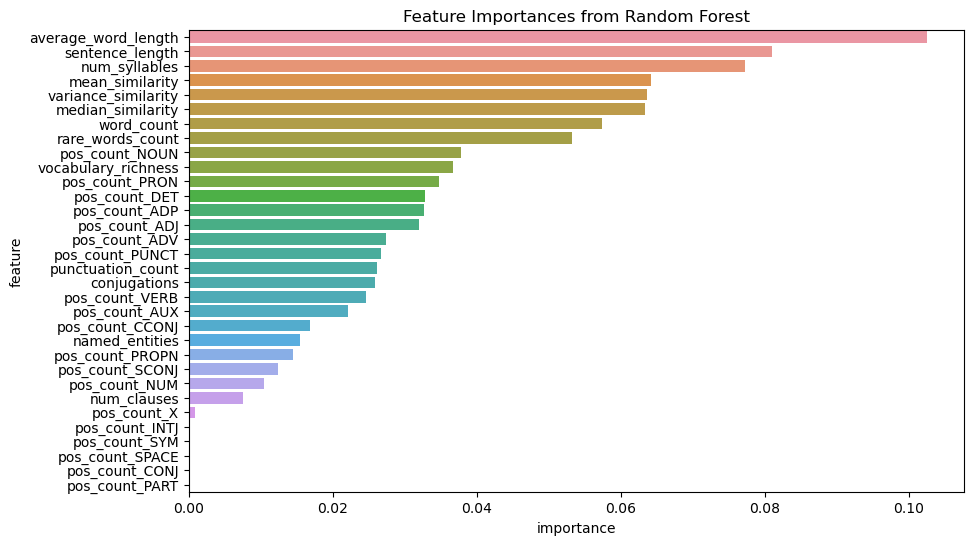

RFE Feature Ranking:
                feature  ranking
0            word_count        1
29      mean_similarity        1
30    median_similarity        1
4         num_syllables        1
31  variance_similarity        1
1   average_word_length        1
2       sentence_length        1
3      rare_words_count        1
14       pos_count_NOUN        2
5   vocabulary_richness        3
17       pos_count_PRON        4
7         pos_count_ADP        5
12        pos_count_DET        6
26    punctuation_count        7
22       pos_count_VERB        8
8         pos_count_ADV        9
6         pos_count_ADJ       10
19      pos_count_PUNCT       11
28         conjugations       12
9         pos_count_AUX       13
18      pos_count_PROPN       14
11      pos_count_CCONJ       15
27       named_entities       16
20      pos_count_SCONJ       17
15        pos_count_NUM       18
25          num_clauses       19
23          pos_count_X       20
13       pos_count_INTJ       21
21        pos_count_SY

In [24]:
# Train a Random Forest model to get feature importances
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances from Random Forest')
plt.show()

# Perform Recursive Feature Elimination (RFE)
rfe = RFE(estimator=rf, n_features_to_select=8) # We will try to select around 20% of the features
rfe.fit(X_train_scaled, y_train)

# Get the ranking of features
rfe_ranking = pd.DataFrame({'feature': feature_names, 'ranking': rfe.ranking_})
rfe_ranking = rfe_ranking.sort_values(by='ranking')

print("RFE Feature Ranking:")
print(rfe_ranking)

In [25]:
# Selecting the features that have a ranking of 1
selected_features = rfe_ranking['feature'][rfe_ranking['ranking'] == 1].tolist()
selected_features

['word_count',
 'mean_similarity',
 'median_similarity',
 'num_syllables',
 'variance_similarity',
 'average_word_length',
 'sentence_length',
 'rare_words_count']

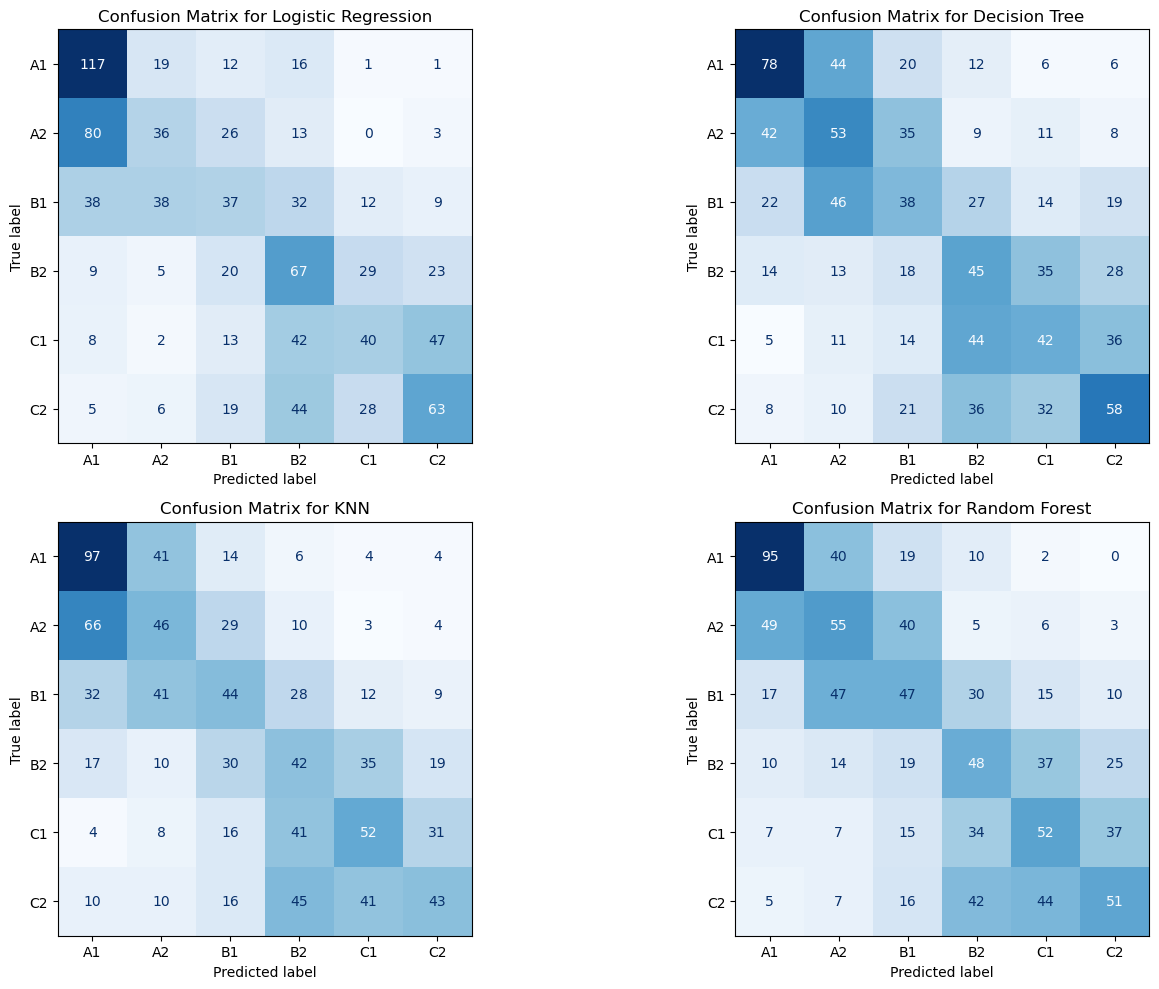

,Logistic Regression,KNN,Decision Tree,Random Forest
Precision,0.366,0.335,0.326,0.361
Recall,0.373,0.336,0.326,0.361
F1-score,0.359,0.331,0.325,0.360
Accuracy,0.375,0.338,0.327,0.362


In [26]:
# Re running the models with the reduced feature list
# Split the data into features (X) and labels (y)
#X = training.drop(columns=['id', 'sentence', 'difficulty'])
X = training[['word_count',
 'mean_similarity',
 'median_similarity',
 'num_syllables',
 'variance_similarity',
 'rare_words_count',
 'sentence_length',
 'average_word_length']]
y = training['difficulty']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier()
}
#-------------------------------------------------------------------------------------------------------
# Train the models
y_preds = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_preds[name] = model.predict(X_test_scaled)

# Initialize a DataFrame to hold the evaluation metrics
metrics_df = pd.DataFrame(index=['Precision', 'Recall', 'F1-score', 'Accuracy'],
                          columns=['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest'])

# Evaluate the models and populate the DataFrame
for name, y_pred in y_preds.items():
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    metrics_df.loc['Precision', name] = np.mean([report[label]['precision'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['Recall', name] = np.mean([report[label]['recall'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['F1-score', name] = np.mean([report[label]['f1-score'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['Accuracy', name] = accuracy_score(y_test, y_pred)

# Plot confusion matrices using ConfusionMatrixDisplay
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for ax, (name, y_pred) in zip(axes, y_preds.items()):
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', colorbar=False)
    disp.ax_.set_title(f'Confusion Matrix for {name}')

plt.tight_layout()
plt.show()
metrics_df_rd = metrics_df.map(lambda x: f"{x:.3f}")
metrics_df_rd

# Introducing TFIDF Vectorization
We lost a little bit of accuracy from selecting only the most important features. This loss seems not to be significant but what can we do to improve accuracy? So far we have not taken into account word frequencies so we will now explore the TFIDF Vectorizer and run the 4 models again.

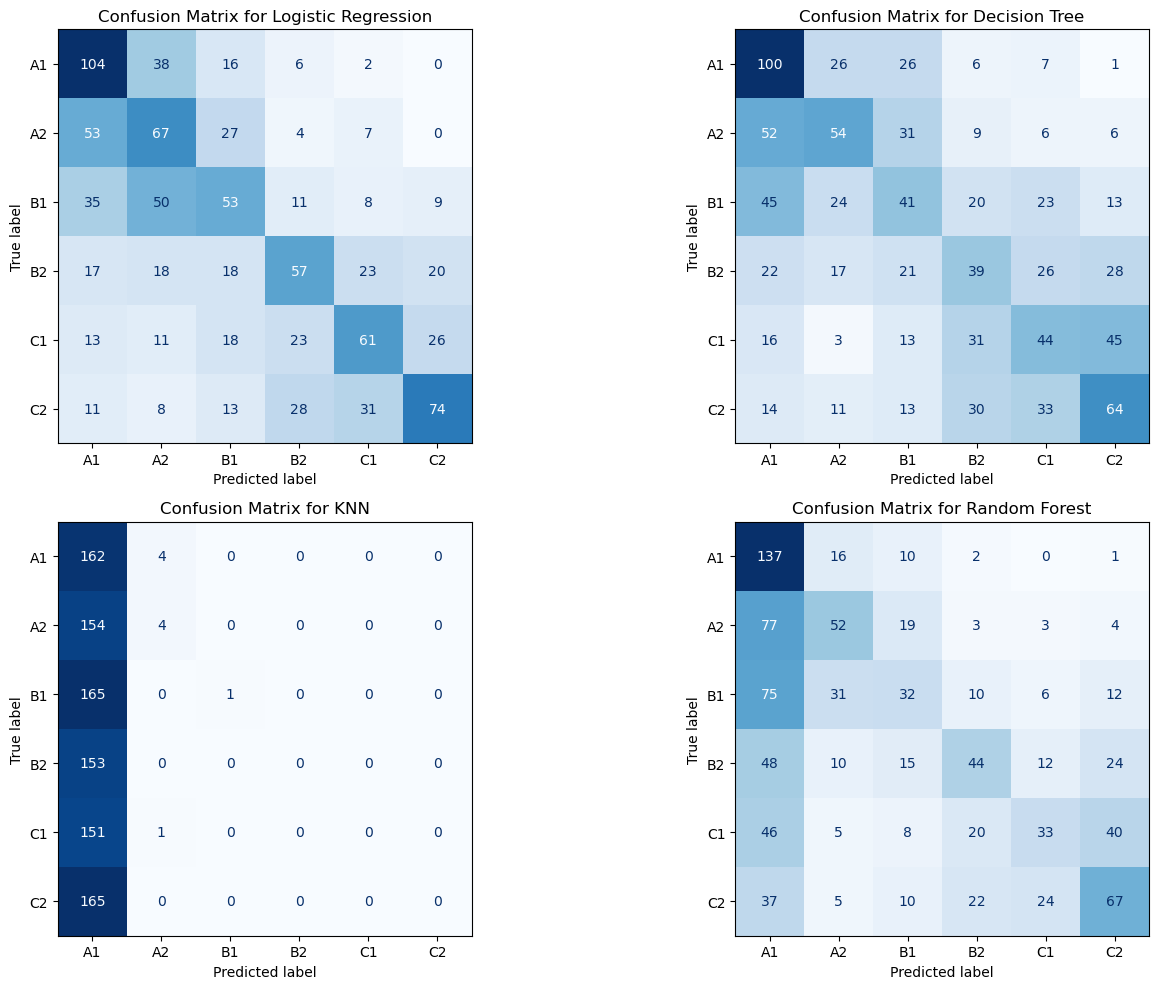

,Logistic Regression,KNN,Decision Tree,Random Forest
Precision,0.440,0.269,0.350,0.403
Recall,0.432,0.168,0.354,0.376
F1-score,0.430,0.058,0.347,0.358
Accuracy,0.433,0.174,0.356,0.380


In [28]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#from nltk.corpus import stopwords
#import nltk
#nltk.download('stopwords')

# Split the data into features (X) and labels (y)
X_text = training['sentence']
y = training['difficulty']

# TF-IDF Vectorization
french_stop_words = stopwords.words('french')
tfidf = TfidfVectorizer(stop_words=french_stop_words) 
X_tfidf = tfidf.fit_transform(X_text).toarray()
tfidf_feature_names = tfidf.get_feature_names_out()

# Convert TF-IDF features to DataFrame
tfidf_df = pd.DataFrame(X_tfidf, columns=tfidf_feature_names)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Scale the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier()
}

#-------------------------------------------------------------------------------------------------------
# Train the models
y_preds = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_preds[name] = model.predict(X_test_scaled)

# Initialize a DataFrame to hold the evaluation metrics
metrics_df = pd.DataFrame(index=['Precision', 'Recall', 'F1-score', 'Accuracy'],
                          columns=['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest'])

# Evaluate the models and populate the DataFrame
for name, y_pred in y_preds.items():
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    metrics_df.loc['Precision', name] = np.mean([report[label]['precision'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['Recall', name] = np.mean([report[label]['recall'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['F1-score', name] = np.mean([report[label]['f1-score'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['Accuracy', name] = accuracy_score(y_test, y_pred)

# Plot confusion matrices using ConfusionMatrixDisplay
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for ax, (name, y_pred) in zip(axes, y_preds.items()):
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', colorbar=False)
    disp.ax_.set_title(f'Confusion Matrix for {name}')

plt.tight_layout()
plt.show()
metrics_df_tf = metrics_df.map(lambda x: f"{x:.3f}")
metrics_df_tf

## Improving KNN classifier
It was stricking to see such a poor performance from the KNN classifier on the sentences vectorized with TFIDF so we decided to dive a bit deeper and try to find the way to improve it. It seems from the confussion matrix that the KNN classifier labels almost all sentences as A1. 
Since we know that our samples are evenly distributed (every difficulty class has 16% sentences), this could mean that the default parameters are not optimal. 
- The default number of neighboors for the KNN Classifier is 5, maybe too small.
- All points are weighted equally but maybe giving more weight to closer neighbors could help.
- Euclidean distance or the line length between two points might not be the best to compare word frequencies.
We will use Bayesian optimisation instead of grid search because grid search might take too long to run

C:\Users\Mariana\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['cosine', 1, 'distance'] before, using random point ['euclidean', 12, 'distance']
  warnings.warn(


Best parameters found by BayesSearchCV on subset: OrderedDict([('metric', 'cosine'), ('n_neighbors', 1), ('weights', 'uniform')])
Classification Report for Optimized KNN:
              precision    recall  f1-score   support

          A1       0.45      0.48      0.47       166
          A2       0.28      0.27      0.28       158
          B1       0.28      0.25      0.27       166
          B2       0.33      0.30      0.32       153
          C1       0.41      0.42      0.41       152
          C2       0.41      0.47      0.44       165

    accuracy                           0.37       960
   macro avg       0.36      0.37      0.36       960
weighted avg       0.36      0.37      0.36       960



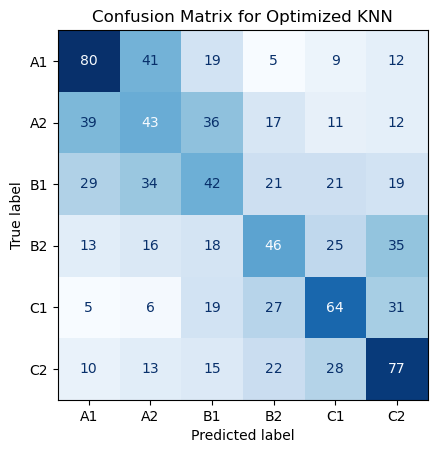

In [30]:
from skopt import BayesSearchCV

# Use a subset of the training data defined above for initial hyperparameter optimization
X_train_subset, _, y_train_subset, _ = train_test_split(X_train_scaled, y_train, test_size=0.85, random_state=42)

# Define the parameter search space
search_space = {
    'n_neighbors': (1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Perform Bayesian Optimization on the subset
opt = BayesSearchCV(knn, search_space, n_iter=30, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
opt.fit(X_train_subset, y_train_subset)

# Get the best parameters from the subset optimization
best_params = opt.best_params_
print("Best parameters found by BayesSearchCV on subset:", best_params)

# Train KNN with the best parameters on the full training data
knn_best = KNeighborsClassifier(**best_params)
knn_best.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_knn = knn_best.predict(X_test_scaled)
print("Classification Report for Optimized KNN:")
print(classification_report(y_test, y_pred_knn))

# Plot confusion matrix
disp_knn = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, cmap='Blues', colorbar=False)
disp_knn.ax_.set_title('Confusion Matrix for Optimized KNN')
plt.show()


## Improving Logistic Regression
Now we will try to improve the model that seems to work the best with sentence difficulty classification.
Specifically we will explore different solvers
We will keep the default penalty because

In [32]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Define the parameter search space
search_space = {
    'penalty': Categorical(['l2']),
    'C': Real(0.01, 100, prior='log-uniform'),
    'solver': Categorical(['newton-cg', 'lbfgs', 'saga']),
    'max_iter': Integer(100, 500)
}

# Initialize the KNN model
#knn = KNeighborsClassifier()
# Initialize the Logistic Regression model
log_reg = LogisticRegression()


# Perform Bayesian Optimization on the subset
opt = BayesSearchCV(log_reg, search_space, n_iter=30, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
opt.fit(X_train_subset, y_train_subset)

# Get the best parameters from the subset optimization
best_params = opt.best_params_
print("Best parameters found by BayesSearchCV on subset:", best_params)

# Train log_reg with the best parameters on the full training data
log_reg_best = LogisticRegression(**best_params)
log_reg_best.fit(X_train_scaled, y_train_scaled)

# Predict and evaluate
y_pred_log_reg = log_reg_best.predict(X_test_scaled)
print("Classification Report for Optimized log_reg:")
print(classification_report(y_test, y_pred_log_reg))

# Plot confusion matrix
disp_log_reg = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log_reg, cmap='Blues', colorbar=False)
disp_log_reg.ax_.set_title('Confusion Matrix for Optimized log_reg')
plt.show()


Best parameters found by BayesSearchCV on subset: OrderedDict([('C', 0.043407384291345365), ('max_iter', 100), ('penalty', 'l2'), ('solver', 'saga')])


NameError: name 'y_train_scaled' is not defined

# Concatenating Features with TFIDF
The KNN model improved from 0.17 to 0.37 accuracy. Maybe if we combine the important features from the previous section and the TF IDF vector we could get a more complete accurate model.

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

          A1       0.51      0.69      0.59       166
          A2       0.40      0.42      0.41       158
          B1       0.45      0.36      0.40       166
          B2       0.47      0.45      0.46       153
          C1       0.46      0.47      0.46       152
          C2       0.55      0.47      0.51       165

    accuracy                           0.48       960
   macro avg       0.47      0.48      0.47       960
weighted avg       0.48      0.48      0.47       960



Classification Report for Decision Tree:

              precision    recall  f1-score   support

          A1       0.53      0.54      0.54       166
          A2       0.36      0.35      0.36       158
          B1       0.27      0.26      0.27       166
          B2       0.27      0.28      0.27       153
          C1       0.33      0.30      0.31       152
          C2       0.36      0.39      0

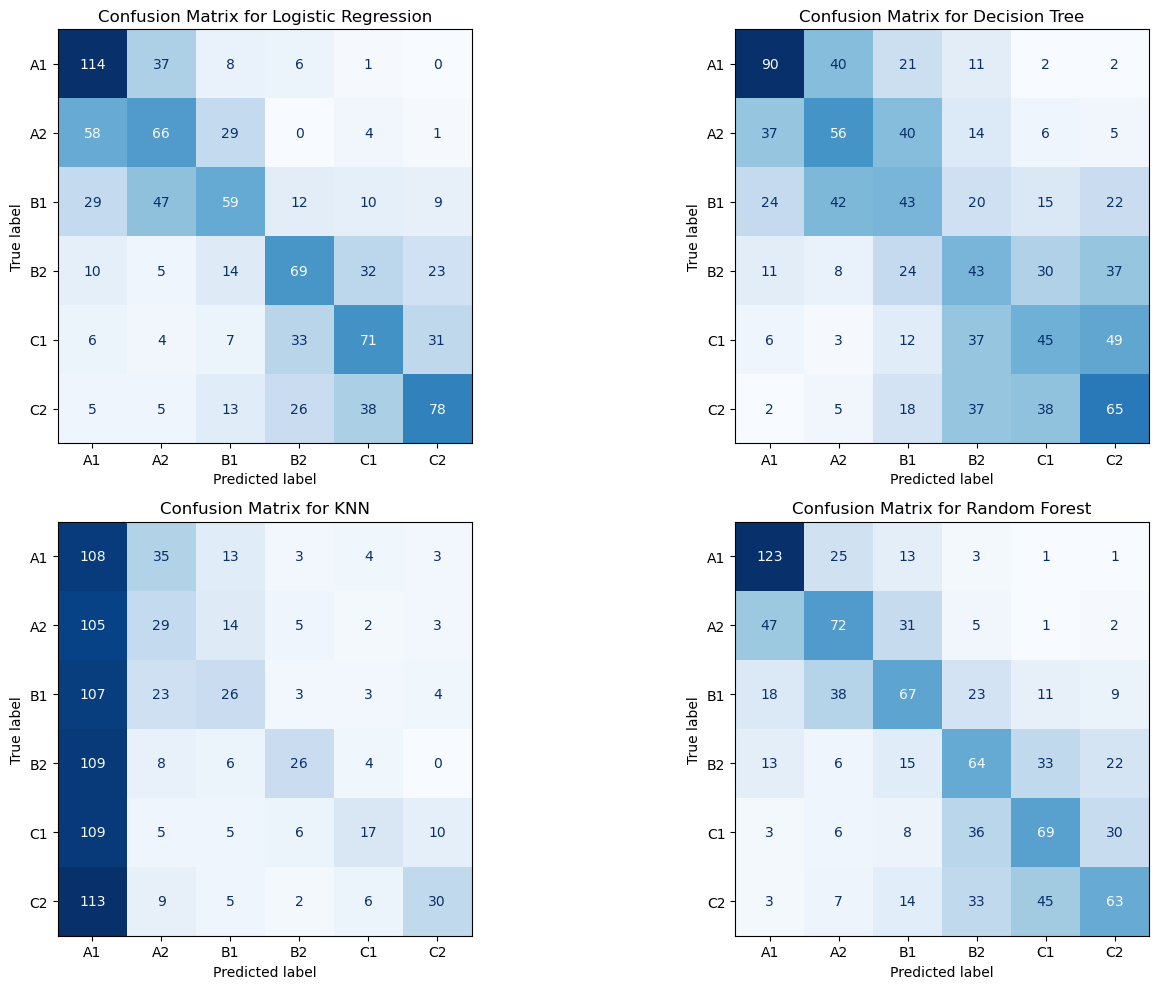

In [102]:
# Split the data into features (X) and labels (y)
X_text = training['sentence']
y = training['difficulty']

# TF-IDF Vectorization
french_stop_words = stopwords.words('french')
tfidf = TfidfVectorizer(stop_words=french_stop_words)  

X_tfidf = tfidf.fit_transform(X_text).toarray()

# Existing features
selected_features = ['word_count', 'rare_words_count', 'average_word_length', 'sentence_length', 
                     'num_syllables', 'vocabulary_richness', 'num_clauses', 'punctuation_count', 
                     'named_entities', 'conjugations', 'mean_similarity', 'median_similarity', 
                     'variance_similarity'] + [f'pos_count_{pos}' for pos in all_pos_tags]

X_existing = training[selected_features]

# Combine existing features with TF-IDF features
X_combined = pd.concat([pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names_out()), X_existing.reset_index(drop=True)], axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Scale features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(metric='cosine', n_neighbors=1, weights='uniform'),#with optimized parameters
    'Random Forest': RandomForestClassifier()
}

# Train the models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)

# Predict the difficulty using the trained models
y_preds = {name: model.predict(X_test_scaled) for name, model in models.items()}

# Evaluate the models with classification_report
for name, y_pred in y_preds.items():
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))
    print("\n" + "="*80 + "\n")

# Plot confusion matrices using ConfusionMatrixDisplay
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for ax, (name, y_pred) in zip(axes, y_preds.items()):
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', colorbar=False)
    disp.ax_.set_title(f'Confusion Matrix for {name}')

plt.tight_layout()
plt.show()

# Gradient Bosting
Accuracy is still not great for any model maybe instead of isolated models we could try combining the power of several 'weak' models (for example Decision Trees) through gradient boosting that optimizes predictions based on gradients and residual errors. 

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

          A1       0.62      0.67      0.64       166
          A2       0.45      0.47      0.46       158
          B1       0.41      0.38      0.39       166
          B2       0.42      0.45      0.43       153
          C1       0.44      0.40      0.42       152
          C2       0.44      0.41      0.42       165

    accuracy                           0.47       960
   macro avg       0.46      0.47      0.46       960
weighted avg       0.46      0.47      0.46       960



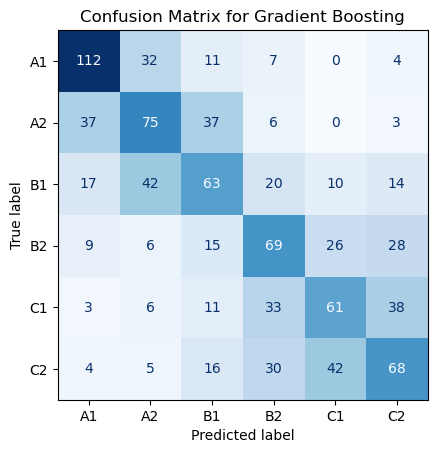

In [106]:
from sklearn.ensemble import GradientBoostingClassifier

# Split the data into features (X) and labels (y)
#X_text = training['sentence']
#y = training['difficulty']

# TF-IDF Vectorization
#french_stop_words = stopwords.words('french')
#tfidf = TfidfVectorizer(stop_words=french_stop_words)  

#X_tfidf = tfidf.fit_transform(X_text).toarray()

# Existing features
#selected_features = ['word_count', 'rare_words_count', 'average_word_length', 'sentence_length', 
#                     'num_syllables', 'vocabulary_richness', 'num_clauses', 'punctuation_count', 
#                     'named_entities', 'conjugations', 'mean_similarity', 'median_similarity', 
#                     'variance_similarity'] + [f'pos_count_{pos}' for pos in all_pos_tags]

#X_existing = training[selected_features]

# Combine existing features with TF-IDF features
#X_combined = pd.concat([pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names_out()), X_existing.reset_index(drop=True)], axis=1)

# Split into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Scale features using Min-Max Scaler
#scaler = MinMaxScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# Initialize and train Gradient Boosting model
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = gb.predict(X_test_scaled)
print("Classification Report for Gradient Boosting:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', colorbar=False)
disp.ax_.set_title('Confusion Matrix for Gradient Boosting')
plt.show()


In [ ]:
# Training data
training = pd.read_csv('https://github.com/cvermno/ML-Project/raw/main/Datasets/training_data.csv')
# Test data
test = pd.read_csv('https://github.com/cvermno/ML-Project/raw/main/Datasets/unlabelled_test_data.csv')

# Tokenizing and Lemmatization

In [ ]:
# Create tokenizer function for preprocessing
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = stopwords.words('french')
    punctuations = string.punctuation +'–' + '—'
    numbers = "0123456789"

    # Create spacy object
    mytokens = nlp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = ([ word.lemma_.lower().strip() for word in mytokens ])

    # Remove stop words and punctuation
    mytokens = ([ word for word in mytokens 
                 if word not in stop_words and word not in punctuations ])

    # Remove sufix like ".[1" in "experience.[1"
    mytokens_2 = []
    for word in mytokens:
        for char in word:
            if (char in punctuations) or (char in numbers):
                word = word.replace(char, "")
        if word != "":
            mytokens_2.append(word)

    # Return preprocessed list of tokens
    return mytokens_2


In [ ]:
# Tokenize texts in training and test data sets
#processed_texts = [spacy_tokenizer(text) for text in texts]
training['processed_sentence'] = training['sentence'].apply(spacy_tokenizer)
training['processed_sentence'] = training['processed_sentence'].apply(lambda x: ' '.join(x))
training.head(5)
#for processed_text in processed_texts:
#    print(processed_text[:20])

In [ ]:
test['processed_sentence'] = test['sentence'].apply(spacy_tokenizer)
test['processed_sentence'] = test['processed_sentence'].apply(lambda x: ' '.join(x))
test.head(5)

### Split and transform

In [ ]:
# split your data into features (X) and target variable (y)
X = training['processed_sentence']
y = training['difficulty']

In [ ]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 123)

In [ ]:
# vectorization
#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#french_stop_words = stopwords.words('french')

#tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words=french_stop_words)
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regresssion

Logistic Regression predicts binary outcomes by estimating probabilities using a logistic function. It fits a curve to decide classes. Example: Predicting whether an email is spam.

In [ ]:
#from sklearn.linear_model import LogisticRegression

# initialize and train the Logistic Regression model
model_LR = LogisticRegression()
model_LR.fit(X_train_tfidf, y_train)

In [ ]:
# predict using the trained model on the scaled test data
y_pred_LR = model_LR.predict(X_test_tfidf)

In [ ]:
# display y_pred values for each X_test
df_pred_LR = pd.DataFrame({'id': X_test.index, 'difficulty': y_pred_LR})
df_pred_LR

### Evaluate the model

In [ ]:
# calculate the test accuracy
accuracy_test_LR = accuracy_score(y_test, y_pred_LR)
print(f'Accurary of Logistic regression classifier on test set: {accuracy_test_LR :.2f}')

In [ ]:
# display the classification report
print(classification_report(y_test,y_pred_LR))

In [ ]:
# record the macro avg values the precision, recall, F1-score
precision_LR = precision_score(y_test, y_pred_LR, average='macro')
print("Precision:", precision_LR)

recall_LR = recall_score(y_test, y_pred_LR, average='macro')
print("Recall:", recall_LR)

f1_LR = f1_score(y_test, y_pred_LR, average='macro')
print("F1-score:", f1_LR)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred_LR)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='g')
plt.xlabel('Predicted')
plt.ylabel('True labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


### Train on the full training data, test on the unlabelled test data

In [ ]:
# split your data into features (X) and target variable (y)
X = training['processed_sentence']
y = training['difficulty']

# define test data
X_full_test = test['processed_sentence']

# vectorization
#tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words=french_stop_words)
#tfidf = TfidfVectorizer()
X_full_train_tfidf = tfidf.fit_transform(X)
X_full_test_tfidf = tfidf.transform(X_full_test)

In [ ]:
# initialize and train the Logistic Regression model
model_LR_full = LogisticRegression()
model_LR_full.fit(X_full_train_tfidf, y)

In [ ]:
# predict using the trained model on the scaled test data
y_full_pred_LR = model_LR_full.predict(X_full_test_tfidf)

In [ ]:
# display y_full_pred values for each X
df_full_pred_LR = pd.DataFrame({'id': X_full_test.index, 'difficulty': y_full_pred_LR})
df_full_pred_LR

### Export the df as csv for kagle submission

In [ ]:
# Export the dataframe as csv
df_full_pred_LR.to_csv("df_LR_lemma.csv", index=False)

# Accuracy score based on kagel submission: [df_LR : 0.455,df_LR_lemma : 0.436, 

# 2. Decision Tree

Decision Tree splits data by features to make decisions, forming a tree structure. Each node represents a decision point. Example: Loan approval based on financial history.

### Train on 80% of training data, test on 20% of training data

In [ ]:
# Initialize the Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier(max_depth=10, random_state=123)

# Train the Decision Tree classifier on the training data
decision_tree_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred_dt = decision_tree_classifier.predict(X_test_tfidf)

In [ ]:
# display y_pred values for each X_test
df_pred_dt = pd.DataFrame({'id': X_test.index, 'difficulty': y_pred_dt})
df_pred_dt

### Evaluate the model

In [ ]:
# calculate the test accuracy
accuracy_test_dt = accuracy_score(y_test, y_pred_dt)
print(f'Accurary of Decision Tree classifier on test set: {accuracy_test_dt :.2f}')

In [ ]:
# display the classification report
print(classification_report(y_test,y_pred_dt))

In [ ]:
# record the macro avg values the precision, recall, F1-score
precision_dt = precision_score(y_test, y_pred_dt, average='macro')
print("Precision:", precision_dt)

recall_dt = recall_score(y_test, y_pred_dt, average='macro')
print("Recall:", recall_dt)

f1_dt = f1_score(y_test, y_pred_dt, average='macro')
print("F1-score:", f1_dt)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='g')
plt.xlabel('Predicted')
plt.ylabel('True labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


### Train on the full training data, test on the unlabelled test data

In [ ]:
# split your data into features (X) and target variable (y)
X = training['processed_sentence']
y = training['difficulty']

# define test data
X_full_test = test['processed_sentence']

# vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_full_train_tfidf = tfidf.fit_transform(X)
X_full_test_tfidf = tfidf.transform(X_full_test)

In [ ]:
# Train your classification algorithm
decision_tree_classifier.fit(X_full_train_tfidf, y)

In [ ]:
# predict using the trained model on the scaled test data
y_full_pred_dt = decision_tree_classifier.predict(X_full_test_tfidf)

In [ ]:
# display y_full_pred values for each X
df_full_pred_dt = pd.DataFrame({'id': X_full_test.index, 'difficulty': y_full_pred_dt})
df_full_pred_dt

### Export the df as csv for kagle submission

In [ ]:
# export the dataframe as csv
df_full_pred_dt.to_csv("df_dt_lemma.csv", index=False)

# accuracy score based on kagel submission: [df_dt.csv : 0.390 ; df_dt_lemma.csv : 0.271

# KNN 

kNN (k-Nearest Neighbors) classifies by majority vote of the nearest k points. No model training, only distance calculations. Example: Recommending similar products.

### Train on 80% of training data, test on 20% of training data

In [ ]:
#Define X and y
X = training['processed_sentence']
y = training['difficulty']
#Define random seed
random_seed = 123

#Split training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# vectorization
#french_stop_words = stopwords.words('french')
#tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words=french_stop_words)
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize the kNN classifier
knn_classifier = KNeighborsClassifier()
# Train the kNN classifier on the training data
knn_classifier.fit(X_train_tfidf, y_train)

In [ ]:
# Make predictions on the test data
y_pred_knn = knn_classifier.predict(X_test_tfidf)

### Evaluate the Model

**General description** 
Precision: Ratio of correctly predicted positive observations to total predicted positives.\
Recall Rate: Ratio of correctly predicted positives to actual positives. \
F1 Score: Harmonic mean of precision and recall. \
Accuracy: Ratio of correctly predicted observations to total observations.

In [ ]:
#Calculate Precision
precision_knn = precision_score(y_test, y_pred_knn, average='macro')
#Calculate recall score
recall_knn = recall_score(y_test, y_pred_knn, average='macro')
# Calculate F1 score
f1_knn = f1_score(y_test, y_pred_knn, average='macro')
# Calculate accuracy score
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"precision:{precision_knn:.2f}")
print(f"recall rate: {recall_knn:.2f}")
print(f"F1 score: {f1_knn:.2f}")
print(f"accuracy: {accuracy_knn:.2f}")

In [ ]:
# display the classification report
print(classification_report(y_test,y_pred_knn))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred_knn)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='g')
plt.xlabel('Predicted')
plt.ylabel('True labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


### Train on the full training data, test on the unlabelled test data

In [ ]:
# split your data into features (X) and target variable (y)
X = training['processed_sentence']
y = training['difficulty']

# define test data
X_full_test = test['processed_sentence']

# vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_full_train_tfidf = tfidf.fit_transform(X)
X_full_test_tfidf = tfidf.transform(X_full_test)

In [ ]:
# Train your classification algorithm
knn_classifier.fit(X_full_train_tfidf, y)

In [ ]:
# predict using the trained model on the scaled test data
y_full_pred_knn = knn_classifier.predict(X_full_test_tfidf)

In [ ]:
# display y_full_pred values for each X
df_full_pred_knn = pd.DataFrame({'id': X_full_test.index, 'difficulty': y_full_pred_knn})
df_full_pred_knn

### Export the df as csv for kagle submission

In [ ]:
# export the dataframe as csv
df_full_pred_knn.to_csv("df_knn_lemma.csv", index=False)

# accuracy score based on kagel submission: [df_knn.csv : 0.175 ; df_knn_lemma.csv : 0.233

# Random Forest

Random Forest is an ensemble of decision trees, averaging predictions to improve accuracy and control overfitting. Each tree uses a subset of data. Example: Detecting fraudulent financial transactions.

### Train on 80% of training data, test on 20% of training data

In [ ]:
#Define X and y
X = training['processed_sentence']
y = training['difficulty']
#Define random seed
random_seed = 123

#Split training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Vectorization
#french_stop_words = stopwords.words('french')
#tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words=french_stop_words)
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#Train the classifier
classifier_rf = RandomForestClassifier(random_state=123)
#Fit to the train data
classifier_rf.fit(X_train_tfidf, y_train)

In [ ]:
#Predict with Random Forest
y_pred_rf = classifier_rf.predict(X_test_tfidf)

### Evaluate the Model

**General description** 
Precision: Ratio of correctly predicted positive observations to total predicted positives.\
Recall Rate: Ratio of correctly predicted positives to actual positives. \
F1 Score: Harmonic mean of precision and recall. \
Accuracy: Ratio of correctly predicted observations to total observations.

In [ ]:
#Calculate Precision
precision_rf = precision_score(y_test, y_pred_rf, average='macro')
#Calculate recall score
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
# Calculate F1 score
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
# Calculate accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"precision:{precision_rf:.2f}")
print(f"recall rate: {recall_rf:.2f}")
print(f"F1 score: {f1_rf:.2f}")
print(f"accuracy: {accuracy_rf:.2f}")

In [ ]:
# Display the classification report
print(classification_report(y_test,y_pred_rf))

In [ ]:
# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='g')
plt.xlabel('Predicted')
plt.ylabel('True labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


### Train on the full training data, test on the unlabelled test data

In [ ]:
# split your data into features (X) and target variable (y)
X = training['processed_sentence']
y = training['difficulty']

# define test data
X_full_test = test['processed_sentence']

# vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_full_train_tfidf = tfidf.fit_transform(X)
X_full_test_tfidf = tfidf.transform(X_full_test)

In [ ]:
# Train your classification algorithm
classifier_rf.fit(X_full_train_tfidf, y)

In [ ]:
# predict using the trained model on the scaled test data
y_full_pred_rf = classifier_rf.predict(X_full_test_tfidf)

In [ ]:
# display y_full_pred values for each X
df_full_pred_rf = pd.DataFrame({'id': X_full_test.index, 'difficulty': y_full_pred_rf})
df_full_pred_rf

### Export the df as csv for kagle submission

In [ ]:
# export the dataframe as csv
df_full_pred_rf.to_csv("df_rf_lemma.csv", index=False)

# accuracy score based on kagel submission: [df_rf.csv :  ; df_rf_lemma.csv : 0.391

# Exploring data

In [ ]:
#Identifiying most repeated words
#max_word = tf_idf.sum(axis=0).sort_values(ascending=False)
#max_word.head(20)

In [ ]:
#merged = pd.merge(training, tf_idf, left_index=True, right_index=True)
#merged.head(5)

In [ ]:
#difficulties = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
#for i in difficulties:
#    temp_df = merged[merged['difficulty']=='i']
#    temp_df = temp_df.drop(columns=['id', 'sentence', 'difficulty'])
#    max_word = temp_df.sum(axis=0).sort_values(ascending=False)
#    print(i, max_word.head(10))

In [ ]:
#from nltk.tokenize import word_tokenize
#nltk.download('punkt')

#parameters = training.copy()

# Define a function to count words and numbers
#def count_elements(text):
#    # Tokenize the sentence
#    tokens = word_tokenize(text)
#    # Count tokens
#    return len(tokens)

# Step 4: Apply the function to the 'sentence' column
#parameters['word_count'] = parameters['sentence'].apply(count_elements)

#parameters.head(5)


In [ ]:
#word_count = parameters.groupby('difficulty')['word_count'].mean()
#word_count

# Other techniques

# Compare accuracies between the models

# Le Petit Prince

In [ ]:
import nltk
nltk.download('punkt')


In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize

# Ensure that necessary NLTK resources are downloaded
nltk.download('punkt')

# Function to read the text file, tokenize it into sentences, and save to CSV
def text_to_csv(filename, output_csv):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
        sentences = sent_tokenize(text)  # Tokenizes the text into sentences

    # Create a DataFrame and save to CSV
    df = pd.DataFrame(sentences, columns=['Sentence'])
    df.to_csv(output_csv, index=False, encoding='utf-8')

# Main function to control the workflow
def main():
    text_to_csv('lepetitprinceexupery.txt', 'sentences_pp.csv')  # Replace 'your_book.txt' with your file's path
    text_to_csv('letrangercamus.txt', 'sentences_le.csv')  # Replace 'your_book.txt' with your file's path

if __name__ == '__main__':
    main()


In [ ]:
pp = pd.read_csv('sentences_pp.csv')
print(pp.shape)
pp.head(5)

In [ ]:
pp.to_csv('pp.csv')

In [ ]:
le = pd.read_csv('sentences_le.csv')
print(le.shape)
le.head(5)

In [ ]:
pp_le = pd.concat([pp,le],axis=0)
pp_le

# Open AI

In [ ]:
pip install openai

In [ ]:
import openai
import os

# It's better to use an environment variable to keep your key secure
openai.api_key = os.getenv('OPENAI_API_KEY')

In [ ]:
def classify_sentence_difficulty(sentence):
    try:
        response = openai.Completion.create(
            model="text-davinci-002",  # Use an appropriate model
            prompt=f"Classify the difficulty of this French sentence into CEFR levels (A1, A2, B1, B2, C1, C2): '{sentence}'",
            temperature=0,
            max_tokens=60
        )
        return response.choices[0].text.strip()
    except Exception as e:
        return str(e)  # Return the error message if something goes wrong


In [ ]:
test = pd.read_csv('https://github.com/cvermno/ML-Project/raw/main/Datasets/unlabelled_test_data.csv')
test.to_csv('test.csv')

In [ ]:
X = test['sentence'].tolist()

In [ ]:
import pandas as pd

def update_csv_with_difficulty(filename):
    # Read the existing CSV file
    df = pd.read_csv(filename)
    
    # Apply the classification function to each sentence
    df['difficulty'] = df['sentence'].apply(classify_sentence_difficulty)
    
    # Save the updated DataFrame back to CSV
    df.to_csv(filename, index=False)

# Example usage
update_csv_with_difficulty('test.csv')


In [ ]:
test_2

In [ ]:
example_sentence = "Il fait beau aujourd'hui."
difficulty = classify_sentence_difficulty(example_sentence)
print("The difficulty level of the sentence is:", difficulty)
